<a href="https://colab.research.google.com/github/geithelmasri/AAI614_Geith1/blob/main/Gen_AI_week2_VAE_fashoin_MINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoder (VAE)**

Autoencoders are a type of neural network designed to learn efficient data representations, primarily for the purpose of dimensionality reduction or feature learning.

Autoencoders consist of two main parts:

**The encoder:** Compresses the input data into a lower-dimensional latent space.

**The decoder:** Reconstructs the original data from this compressed representation.

VAE.avif

*VAE Components:*

**Encoder:** Maps input data to a latent space, producing mean and variance vectors.

**Latent Space:** Represents the compressed features of the data (mean and variance form a Gaussian distribution).

**Decoder:** Reconstructs data from the latent space, generating new data samples from the distribution.

**Encoder:** Takes the input data (28x28 images) and passes it through fully connected layers to produce mean (mu) and log-variance (logvar) for the latent space representation.

**Reparameterization:** A random noise (eps) is sampled and combined with the mean and variance to generate a latent vector z (using the reparameterization trick).

**Decoder:** The latent vector z is passed through the decoder to reconstruct the image.

**Loss Function:** The loss consists of a reconstruction loss (how well the VAE reconstructs the input) and a KL divergence term (regularizing the latent space to be close to a unit Gaussian).

**Training:** The model is trained using backpropagation, with Adam as the optimizer.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# prompt: Load and Preprocess the fashion MNIST Dataset

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the data to include a channel dimension (for CNNs)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000,)


In [ ]:
# 2. Define the VAE Model
# ----------------------
class VAE(keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # 2.1 Encoder
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(28, 28, 1)),
            layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim * 2),
        ])

        # 2.2 Decoder
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(7 * 7 * 64, activation='relu'),
            layers.Reshape((7, 7, 64)),
            layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same'),
        ])
       # 2.3 Encoder Function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    # 2.4 Reparameterization Trick
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * 0.5) + mean

    # 2.5 Decoder Function
    def decode(self, z):
        return self.decoder(z)

    # 2.6 Call Function
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        decoded = self.decode(z)
        return decoded, mean, logvar

In [ ]:

# 3. Define the Loss Function

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    # Ensure logvar has a shape, even if it's a scalar
    logvar = tf.convert_to_tensor(logvar, dtype=tf.float32)
    logvar = tf.expand_dims(logvar, axis=-1) if logvar.ndim == 0 else logvar # Add dimension if logvar is scalar
    # Repeat logvar to match sample dimension
    logvar = tf.repeat(logvar, repeats=tf.shape(sample)[-1] // tf.shape(logvar)[-1], axis=-1)

    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )

def compute_loss(model, x):
    decoded, mean, logvar = model(x)
    flattened_x = tf.reshape(x, [-1, 28 * 28])
    flattened_decoded = tf.reshape(decoded, [-1, 28 * 28])
    logpxz = log_normal_pdf(flattened_x, flattened_decoded, logvar)
    # Pass a valid logvar for logpz and logqz_x
    logpz = log_normal_pdf(model.reparameterize(mean, logvar), 0.0, tf.zeros_like(logvar))
    logqz_x = log_normal_pdf(model.reparameterize(mean, logvar), mean, logvar)
    return -tf.reduce_mean(logpxz + logpz - logqz_x)

# 4. Define the Training Step
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# 5. Train the VAE
# -----------------
latent_dim = 2
vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 10
batch_size = 32

for epoch in range(1, epochs + 1):
    for batch_idx in range(x_train.shape[0] // batch_size):
        x_batch = x_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        loss = train_step(vae, x_batch, optimizer)

    print('Epoch: {}, Loss: {}'.format(epoch, loss))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch: 1, Loss: -212.6865997314453
Epoch: 2, Loss: -246.11917114257812
Epoch: 3, Loss: -269.7985534667969
Epoch: 4, Loss: -282.18170166015625
Epoch: 5, Loss: -293.2113037109375
Epoch: 6, Loss: -301.2808837890625
Epoch: 7, Loss: -308.25048828125
Epoch: 8, Loss: -309.99896240234375
Epoch: 9, Loss: -311.68707275390625
Epoch: 10, Loss: -318.01068115234375


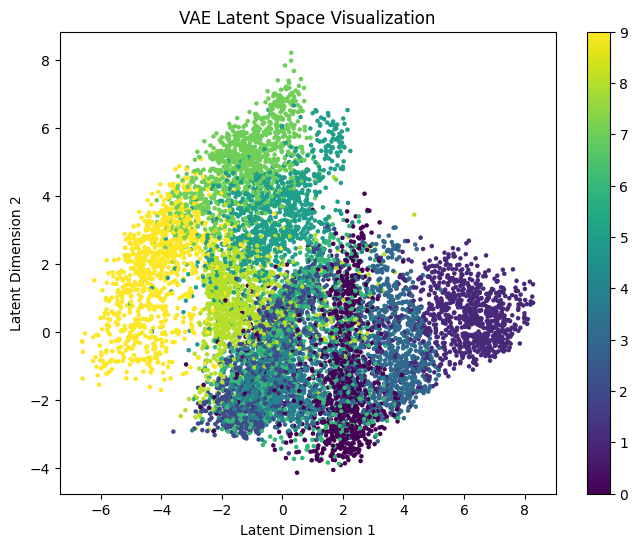

In [ ]:
# 6. Visualize the Latent Space
# -----------------------------
def plot_latent_space(model, x_test, y_test):
    """Encodes the test set to the latent space and plots the results."""
    mean, _ = model.encode(x_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(mean[:, 0], mean[:, 1], c=y_test, cmap='viridis', s=5)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("VAE Latent Space Visualization")
    plt.colorbar()
    plt.show()

plot_latent_space(vae, x_test, y_test)

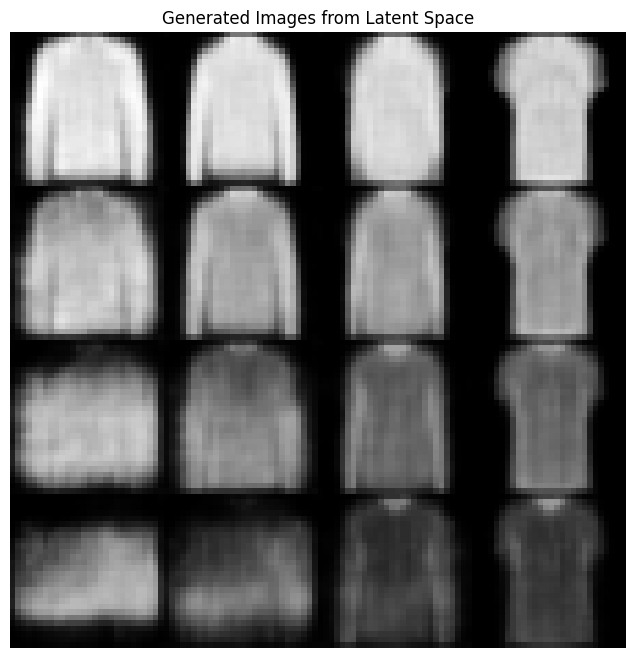

In [ ]:
# 7. Generate Images from Latent Space
# ---------------------------------------
def generate_and_save_images(model, epoch):
    """Generates and saves images from the latent space."""
    # Create a grid of points in the latent space
    num_samples = 16
    grid_x = np.linspace(-2, 2, 4)  # Adjust range as needed
    grid_y = np.linspace(-2, 2, 4)
    images = np.zeros((4 * 28, 4 * 28))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            z_sample = tf.cast(z_sample, dtype=tf.float32)
            decoded = model.decode(z_sample)
            img = tf.reshape(decoded[0], (28, 28)).numpy()
            images[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img

    plt.figure(figsize=(8, 8))
    plt.imshow(images, cmap='gray')
    plt.axis('off')
    plt.title("Generated Images from Latent Space")
    plt.savefig('generated_images_epoch_{:04d}.png'.format(epoch))
    plt.show()

generate_and_save_images(vae, epochs)